In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization, Embedding, Dropout, Concatenate, Input, Flatten
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
# from keras.preprocessing import text
# from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import itertools

In [2]:
# Load and merge datasets
df1 = pd.read_csv(r'C:\Users\shrih\OneDrive\Documents\mini project\pdb_data_no_dups.csv')
df2 = pd.read_csv(r'C:\Users\shrih\OneDrive\Documents\mini project\pdb_data_seq.csv')
df = df1.merge(df2, how='inner', on='structureId').drop_duplicates(["sequence"])

# Drop rows with missing labels
df = df.dropna(subset=['classification', 'sequence'])

# Select proteins
df = df[df.macromoleculeType_x == 'Protein']
df.reset_index(drop=True, inplace=True)

print(df.shape)
df.head()

(87761, 18)


,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y
0,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
1,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein
2,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
3,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167,Protein
4,104L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,332,2.80,37541.04,NaN,NaN,3.04,59.49,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSAA...,332,Protein


In [3]:
# Filter based on residue count
df = df[df.residueCount_x < 1200]

In [4]:
# Count numbers of instances per class
cnt = Counter(df.classification)
top_classes = 10
sorted_classes = cnt.most_common()[:top_classes]
classes = [c[0] for c in sorted_classes]
counts = [c[1] for c in sorted_classes]

# Apply class filter to dataframe
df = df[df.classification.isin(classes)]

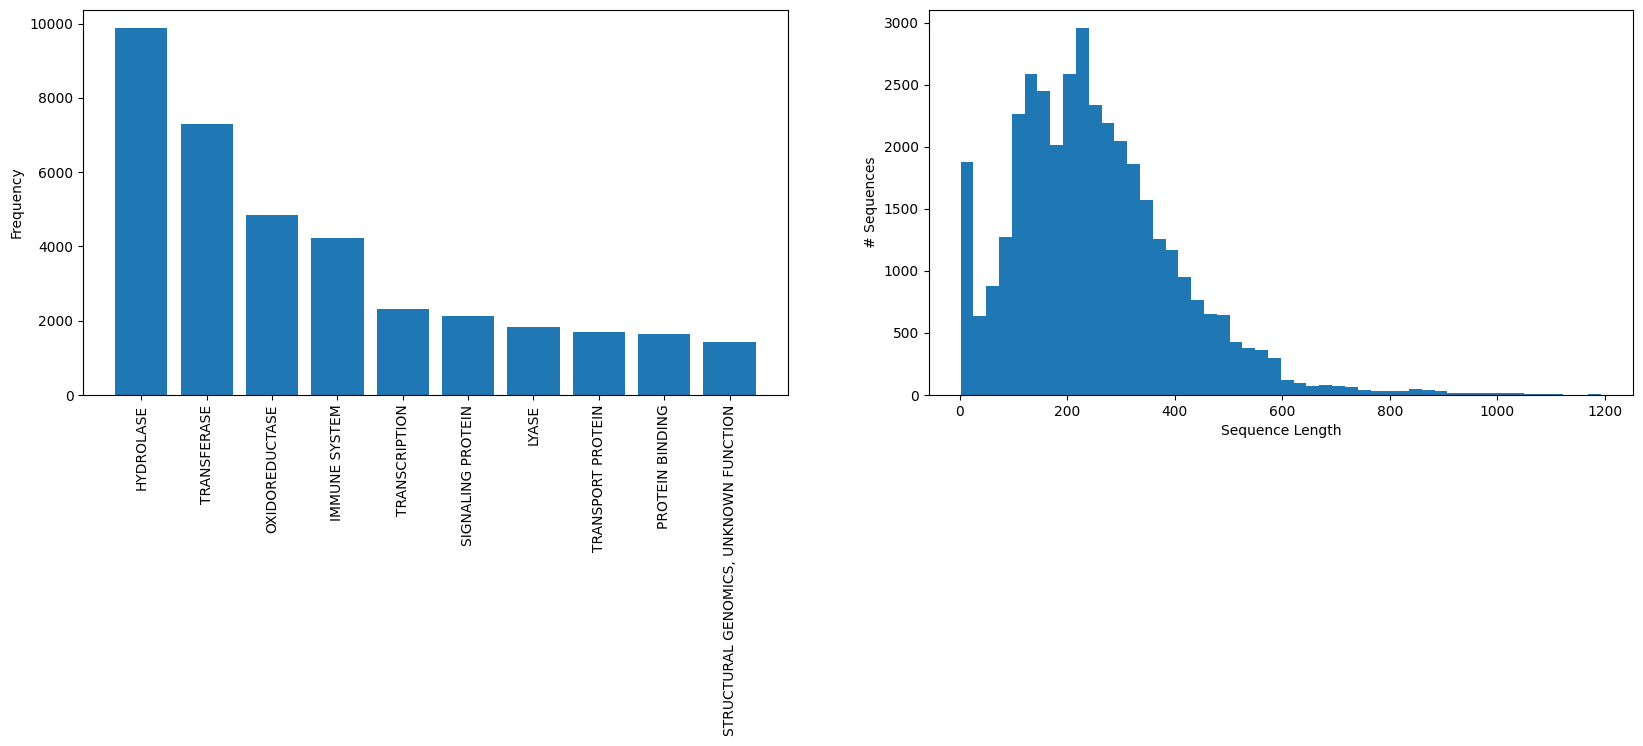

In [5]:
# Visualize class distribution and sequence lengths
fig, axarr = plt.subplots(1, 2, figsize=(20, 5))
axarr[0].bar(range(len(classes)), counts)
plt.sca(axarr[0])
plt.xticks(range(len(classes)), classes, rotation='vertical')
axarr[0].set_ylabel('Frequency')

seqs = df.sequence.values
lengths = [len(s) for s in seqs]
axarr[1].hist(lengths, bins=50, density=False)
axarr[1].set_xlabel('Sequence Length')
axarr[1].set_ylabel('# Sequences')
plt.show()

In [6]:
# Transform labels to one-hot encoding
lb = LabelBinarizer()
Y = lb.fit_transform(df.classification)

# Tokenize sequences
max_length = 350
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
X = tokenizer.texts_to_sequences(seqs)
X = sequence.pad_sequences(X, maxlen=max_length)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [7]:
units = 256
num_filters = 32
filter_sizes = (3, 5, 9, 15, 21)
embedding_dim = 128  # You need to define the embedding dimension

conv_blocks = []
embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim, input_length=max_length)

sequence_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
z = Dropout(0.1)(embedded_sequences)

for sz in filter_sizes:
    conv = Conv1D(filters=num_filters, kernel_size=sz, padding="valid", activation="relu", strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(0.25)(z)
z = BatchNormalization()(z)
z = Dense(units, activation="relu")(z)
z = BatchNormalization()(z)
predictions = Dense(top_classes, activation="softmax")(z)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


c:\Users\shrih\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 350)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 350, 128)  │      3,328 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 350, 128)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 348, 32)   │     12,320 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 346, 32)   │     20,512 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 342, 32)   │     36,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 336, 32)   │     61,472 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 330, 32)   │     86,048 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 174, 32)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 173, 32)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 171, 32)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 168, 32)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 165, 32)   │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 5568)      │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 5536)      │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 5472)      │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 5376)      │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 5280)      │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 27232)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,304,746 (27.87 MB)

 Trainable params: 7,249,770 (27.66 MB)

 Non-trainable params: 54,976 (214.75 KB)

None


In [8]:
es2 = EarlyStopping(monitor='val_accuracy', verbose=1, patience=10,restore_best_weights=True)
history2 = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.15, callbacks=[es2])

Epoch 1/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 114s 270ms/step - accuracy: 0.4005 - loss: 1.8905 - val_accuracy: 0.5228 - val_loss: 1.5514
Epoch 2/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 100s 251ms/step - accuracy: 0.6583 - loss: 1.0311 - val_accuracy: 0.5724 - val_loss: 1.3400
Epoch 3/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 108s 273ms/step - accuracy: 0.7958 - loss: 0.6437 - val_accuracy: 0.5883 - val_loss: 1.4613
Epoch 4/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 105s 265ms/step - accuracy: 0.8497 - loss: 0.4776 - val_accuracy: 0.5807 - val_loss: 1.5907
Epoch 5/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 106s 266ms/step - accuracy: 0.8816 - loss: 0.3728 - val_accuracy: 0.5992 - val_loss: 1.6924
Epoch 6/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 106s 268ms/step - accuracy: 0.9035 - loss: 0.3105 - val_accuracy: 0.6035 - val_loss: 1.6763
Epoch 7/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 105s 265ms/step - accuracy: 0.9186 - loss: 0.2701 - val_accuracy: 0.5959 - val_loss: 1.8147
Epoch 8/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 105s 265ms/step - accuracy: 

In [9]:
# Evaluate the model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("Model - Train Accuracy: {:.2f}%".format(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1)) * 100))
print("Model - Test Accuracy: {:.2f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1)) * 100))

932/932 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Model - Train Accuracy: 93.71%
Model - Test Accuracy: 61.79%


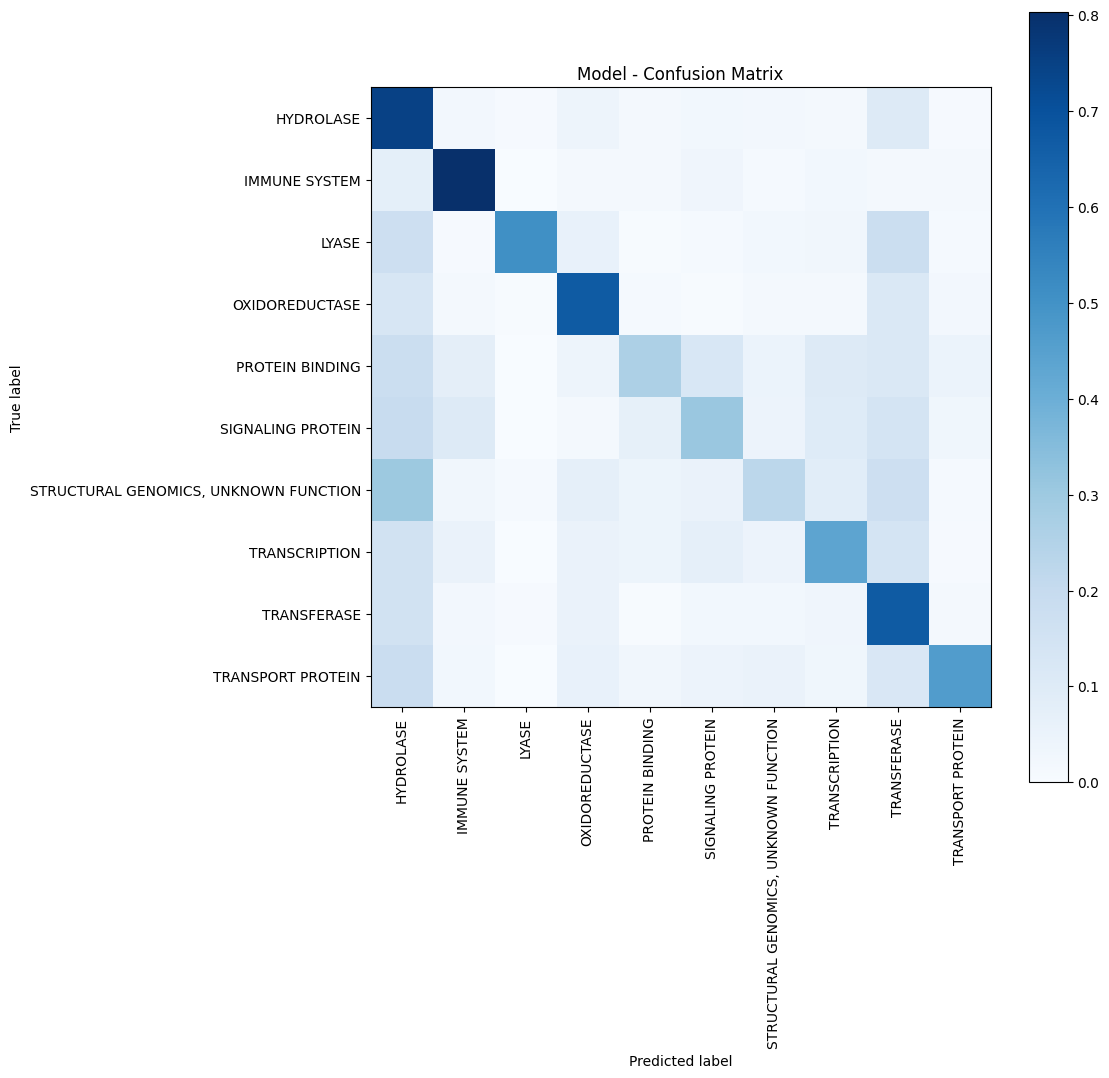

                                       precision    recall  f1-score   support

                            HYDROLASE       0.64      0.75      0.69      1963
                        IMMUNE SYSTEM       0.78      0.80      0.79       872
                                LYASE       0.84      0.51      0.63       386
                       OXIDOREDUCTASE       0.69      0.67      0.68       912
                      PROTEIN BINDING       0.43      0.26      0.32       353
                    SIGNALING PROTEIN       0.37      0.31      0.34       425
STRUCTURAL GENOMICS, UNKNOWN FUNCTION       0.25      0.22      0.23       267
                        TRANSCRIPTION       0.46      0.43      0.44       470
                          TRANSFERASE       0.61      0.67      0.64      1473
                    TRANSPORT PROTEIN       0.59      0.46      0.52       335

                             accuracy                           0.62      7456
                            macro avg       0.57  

In [10]:
# Compute confusion matrix for the model
cm2 = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
cm2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
plt.imshow(cm2, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Model - Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_, zero_division=0))